In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
f_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name) # 한글처리

import warnings 
warnings.filterwarnings(action="ignore") #waring을 무시하도록 처리

# 챗봇에게 채팅한 데이터 가져오기

In [3]:
df = pd.read_csv('../Project4 Data/ChatBotData.csv')
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
df = df.drop(['A'], axis='columns').rename({'Q':'Message', 'label':'category'}, axis=1)
df

,Message,category
0,12시 땡!,0
1,1지망 학교 떨어졌어,0
2,3박4일 놀러가고 싶다,0
3,3박4일 정도 놀러가고 싶다,0
4,PPL 심하네,0
...,...,...
11818,훔쳐보는 것도 눈치 보임.,2
11819,훔쳐보는 것도 눈치 보임.,2
11820,흑기사 해주는 짝남.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,2


In [6]:
df['category'].replace({0: '일상', 1: '이별(부정)', 2: '사랑(긍정)'}, inplace=True)
df

,Message,category
0,12시 땡!,일상
1,1지망 학교 떨어졌어,일상
2,3박4일 놀러가고 싶다,일상
3,3박4일 정도 놀러가고 싶다,일상
4,PPL 심하네,일상
...,...,...
11818,훔쳐보는 것도 눈치 보임.,사랑(긍정)
11819,훔쳐보는 것도 눈치 보임.,사랑(긍정)
11820,흑기사 해주는 짝남.,사랑(긍정)
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,사랑(긍정)


In [7]:
# 데이터에 사용된 중복이 없는 전체 단어 갯수를 리턴
def get_vocab_size(df):
    results = set()
    df['Message'].str.lower().str.split().apply(results.update)
    return len(results)

In [8]:
vocab_size = get_vocab_size(df)

In [9]:
Messages = df['Message'].to_list()
encoded_Messages = [one_hot(Message, vocab_size) for Message in Messages]

In [10]:
# 데이터에서 가장 긴 문장의 단어 갯수를 리턴
def get_max_length(df):
    max_length = 0
    for row in df['Message']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

max_length = get_max_length(df)
print(max_length)

15


In [11]:
# 각 문장마다 제로패딩을 넣어서 가장 긴 문장과 길이를 동일하게 만듦
padded_Messages_encoding = pad_sequences(encoded_Messages, maxlen=max_length, padding='post')

In [12]:
# 문장의 벡터 확인
padded_Messages_encoding

array([[ 2282,   911,     0, ...,     0,     0,     0],
       [ 2513, 10267, 11184, ...,     0,     0,     0],
       [11956,  4841, 13081, ...,     0,     0,     0],
       ...,
       [13783,    85, 13550, ...,     0,     0,     0],
       [ 9303, 13426,  3603, ...,     0,     0,     0],
       [11877,  6236,     0, ...,     0,     0,     0]])

In [13]:
# 분류 항목(레이블)을 원-핫 인코딩: 3가지로 분류
categories = df['category'].to_list()
def category_encode(category):
    if category == '일상':
        return [1,0,0]
    elif category == '이별(부정)':
        return [0,1,0]
    else:
        return [0,0,1]

encoded_category = [category_encode(category) for category in categories]

In [14]:
print(encoded_category[0])
print(encoded_category[1111])
print(encoded_category[11111])
print(encoded_category[7777])
print(encoded_category[5555])

[1, 0, 0]
[1, 0, 0]
[0, 0, 1]
[0, 1, 0]
[0, 1, 0]


In [15]:
model = Sequential()

# 문맥 벡터 생성 단계
model.add(Embedding(vocab_size, 5, input_length=max_length))
model.add(LSTM(64))
#-----------------------------------------------
# 분류 단계
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
#-----------------------------------------------
#모델 컴파일
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

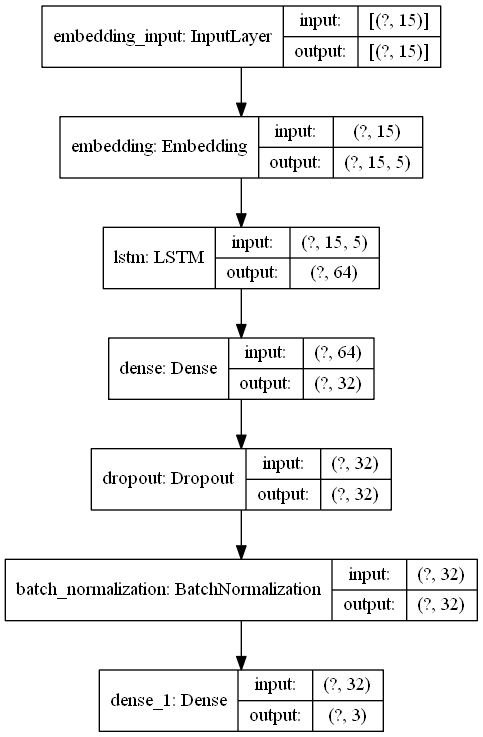

In [16]:
# 모델 시각화
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(padded_Messages_encoding), # 데이터 프레임의 속성들
                 np.array(encoded_category), # 맞추어야 할 정답
                 test_size = 0.2, # 테스트데이터 20%지정, 훈련데이터 80%할당
                 stratify = np.array(encoded_category), # 쏠려서 분배되는것을 방지
                 shuffle= True, #데이터 섞기
                 random_state = 28 #seed값
                )

In [19]:
X_train.shape

(9458, 15)

In [20]:
print('Train 진행')
#조기종료
es = EarlyStopping(monitor='loss', patience=3, verbose=2, mode='auto')
#체크포인트
mc = ModelCheckpoint('best_model.h5', monitor='accuracy', verbose=2, mode='auto', save_best_only=True)
history = model.fit(X_train, Y_train, epochs=100, callbacks=[es, mc]) #batch_size는 디폴트로 설정

Train 진행
Epoch 1/100
290/296 [============================>.] - ETA: 0s - loss: 0.9739 - accuracy: 0.5094
Epoch 00001: accuracy improved from -inf to 0.51036, saving model to best_model.h5
296/296 [==============================] - 2s 5ms/step - loss: 0.9723 - accuracy: 0.5104
Epoch 2/100
290/296 [============================>.] - ETA: 0s - loss: 0.7230 - accuracy: 0.6754
Epoch 00002: accuracy improved from 0.51036 to 0.67604, saving model to best_model.h5
296/296 [==============================] - 2s 6ms/step - loss: 0.7218 - accuracy: 0.6760
Epoch 3/100
290/296 [============================>.] - ETA: 0s - loss: 0.5630 - accuracy: 0.7777
Epoch 00003: accuracy improved from 0.67604 to 0.77617, saving model to best_model.h5
296/296 [==============================] - 2s 6ms/step - loss: 0.5660 - accuracy: 0.7762
Epoch 4/100
291/296 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.8221
Epoch 00004: accuracy improved from 0.77617 to 0.82153, saving model to best_mode

291/296 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9821
Epoch 00032: accuracy did not improve from 0.98403
296/296 [==============================] - 2s 5ms/step - loss: 0.0513 - accuracy: 0.9819
Epoch 33/100
291/296 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9822
Epoch 00033: accuracy did not improve from 0.98403
296/296 [==============================] - 2s 5ms/step - loss: 0.0589 - accuracy: 0.9818
Epoch 34/100
291/296 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9812
Epoch 00034: accuracy did not improve from 0.98403
296/296 [==============================] - 2s 5ms/step - loss: 0.0501 - accuracy: 0.9810
Epoch 00034: early stopping


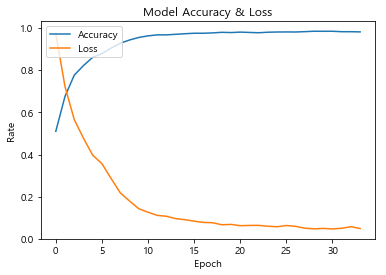

In [21]:
# 훈련 과정 시각화 (정확도와 손실률)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.legend(['Accuracy','Loss'], loc='upper left')
plt.show()

In [22]:
# 트레이닝 학습 결과
score, acc = model.evaluate(X_train, Y_train, verbose=2)
print('Train accuracy:', acc)

296/296 - 0s - loss: 0.0299 - accuracy: 0.9893
Train accuracy: 0.989321231842041


In [23]:
from sklearn.metrics import accuracy_score
# 테스트 결과
Y_pred = model.predict(X_test)
Y_pred_class = np.argmax(Y_pred, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)
print('Test accuracy:', accuracy_score(Y_pred_class, Y_test_class))

Test accuracy: 0.6921775898520085


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 5)             71410     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 91,637
Trainable params: 91,573
Non-trainable params: 64
___________________________________________________

In [25]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(Y_test_class,Y_pred_class))
print(confusion_matrix(Y_test_class,Y_pred_class))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1058
           1       0.61      0.70      0.65       714
           2       0.73      0.67      0.70       593

    accuracy                           0.69      2365
   macro avg       0.69      0.69      0.69      2365
weighted avg       0.70      0.69      0.69      2365

[[739 239  80]
 [146 503  65]
 [114  84 395]]


In [26]:
# 모델 저장
model.save('model1.h5')
model.save_weights('model1_w.h5')